In [1]:
import keras_bitcoin
import dataset
import collections
import pandas as pd
from itertools import permutations, combinations
from sklearn.model_selection import train_test_split
import moment
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [18]:
#df = pd.read_csv("../Data/LDA_Data/reduceData3.csv")
#df = dataset.put_on_label_dataset(df, "day", binary=False, values = [-0.5, -0.2, 0.2, 0.5])

df = dataset.get_labeled_dataset(number_of_file=100, binary= False, values = [-5, -0.2, 0.2, 5], from_date = "2018-01-01")
print(collections.Counter(df["label"]))

#df = dataset.put_on_label_dataset(df, "date")
df.head()
print(df.shape)
print(df.head())

Number of files loaded :  102
Counter({4: 8112, 1: 6883, 2: 6798, 5: 4564, 3: 1685})
(28042, 8)
                                                text  label        date  \
0          So how does that make it not a currency?       3  2018-01-03   
1  I didn't say it wasn't a currency, I'm just sa...      3  2018-01-03   
2  I don't think spam has ever been a problem in ...      3  2018-01-03   
3  It was electrum wallet bro ._.\r\nMy transacti...      3  2018-01-03   
4  My laptop has 4 GB Ram, I think it can handle ...      3  2018-01-03   

   score  nb_replies  stickied  label_m1  label_m2  
0      2           1     False         4         5  
1      1           0     False         4         5  
2      1           1     False         4         5  
3      1           0     False         4         5  
4      1           0     False         4         5  


In [27]:
def prepare_data(df, number_words = None):
    texts = df["text"]
    texts = keras_bitcoin.encode_data(texts)
    df = df.drop(columns=["text"])
    texts = list(texts[0])
    
    sentence_length = number_words if number_words else len(texts[0])
    for i in range(sentence_length):
        if i < len(texts[0]):
            words = [texts[k][i] for k in range(len(texts))]
        else :
            words = [0 for k in range(len(texts))]
        df[f"word_{i+1}"] = words
        
    df["year"] = [int(str(date)[0:4]) for date in df["date"]]
    df["month"] = [int(str(date)[5:7]) for date in df["date"]]
    df["day"] = [int(str(date)[8:10]) for date in df["date"]]
    df = df.drop(columns=["date"])
    
    return df, sentence_length

In [21]:
df,number_words  = prepare_data(df)

KeyboardInterrupt: 

In [7]:
texts_train, texts_test , labels_train, labels_test = train_test_split(df.drop(columns=["label"]), df["label"] , test_size = 0.20)

In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xg_class = XGBClassifier(objective ='reg:tweedie',
                         max_depth = 8,
                         n_estimators = 50,
                         eta = 0.5,
                         )
xg_class.fit(texts_train,labels_train)
preds = xg_class.predict(texts_test)
accuracy = accuracy_score(labels_test, preds)

In [10]:
print(accuracy)

1.0


In [11]:
mean_squared_error(labels_test, preds)

0.0

In [13]:
df[-1:]

,label,score,nb_replies,stickied,label_m1,label_m2,word_1,word_2,word_3,word_4,...,word_1938,word_1939,word_1940,word_1941,word_1942,word_1943,word_1944,year,month,day
28041,2,16,0,False,5,4,24509,10812,6630,11901,...,0,0,0,0,0,0,0,2018,4,12


In [33]:
last_date = "2018-04-12"
df_test = dataset.get_labeled_dataset(number_of_file=50, binary= False, values = [-5, -0.2, 0.2, 5], from_date = "2018-04-")
print(collections.Counter(df["label"]))


Number of files loaded :  52
Counter({4: 8112, 1: 6883, 2: 6798, 5: 4564, 3: 1685})


In [34]:
df_test, _ = prepare_data(df_test, number_words)

In [36]:
label_test = df_test["label"]
df_test = df_test.drop(columns=["label"])

In [42]:
preds = xg_class.predict(df_test)

In [43]:
print(len(df_test), len(label_test), len(preds))

6615 6615 6615


In [44]:
df_test.shape

(6615, 1952)

In [46]:
mean_squared_error(preds, label_test)

1.635827664399093

In [52]:
res = {"0" : 0, "1" : 0, "2" : 0, "3" : 0, "4" : 0}
diff = []
for i in range(len(label_test)):
    val = abs(list(label_test)[i] - list(preds)[i])
    diff.append(val)
    res[str(val)] += 1
for k in res.keys():
    res[k] /= len(preds) 
res

{'0': 0.562962962962963,
 '1': 0.18110355253212396,
 '2': 0.18412698412698414,
 '3': 0.061526832955404384,
 '4': 0.010279667422524565}

(array([3724.,    0., 1198.,    0.,    0., 1218.,    0.,  407.,    0.,
          68.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

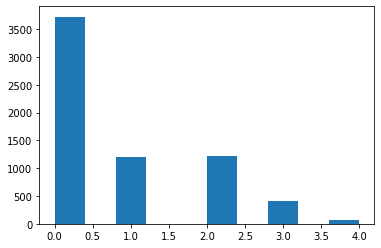

In [56]:
import matplotlib.pyplot as plt

plt.hist(diff, bins = 10)